In [4]:
# Clone the repository and switch to the correct directory
!git clone --branch hackathon-prep https://github.com/adamimos/epsilon-transformers.git
%cd epsilon-transformers

# Step 2: Install the necessary dependencies
!pip install -e .

# Step 3: Install gdown if not already installed
#!pip install gdown

# Step 4: Download the RRXOR experiment data
#!gdown "https://drive.google.com/uc?id=1PYMcdvvJ_FW31rQDBmnNKz9LOyFEcfqQ" -O vfs4q106-rrxor.zip

# Step 5: Unzip the data in the correct location
#!unzip vfs4q106-rrxor.zip -d examples/models/


xcrun: error: active developer path ("/Applications/Xcode.app/Contents/Developer") does not exist
Use `sudo xcode-select --switch path/to/Xcode.app` to specify the Xcode that you wish to use for command line developer tools, or use `xcode-select --install` to install the standalone command line developer tools.
See `man xcode-select` for more details.
[Errno 2] No such file or directory: 'epsilon-transformers'
/Users/dolorious/Downloads
Obtaining file:///Users/dolorious/Downloads
ERROR: file:///Users/dolorious/Downloads does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
from epsilon_transformers.process.processes import ZeroOneR, GoldenMean, Mess3

proc1 = ZeroOneR()
proc2 = GoldenMean(1,1)

print(proc1.transition_matrix)
print(proc2.transition_matrix)
print(proc1.vocab_len)
print(type(proc1.transition_matrix))


ModuleNotFoundError: No module named 'epsilon_transformers'

In [ ]:
from epsilon_transformers.process.Process import Process
import numpy as np

class GluedProcess(Process):
  def __init__(self, proc1, proc2, join_on=dict(), weights=(0.5,0.5)):
        # join_on is a dictionary that maps vocubulary from Process 2 to Process 1
        # So join_on = {0: 1} means that emitting a "0" in Process 2 looks the same
        # as emitting a "1" in Process 1, but all other vocubulary of Process 1
        # is discernable.

        self.name = proc1.name + "+" + proc2.name
        self.proc1 = proc1
        self.proc2 = proc2
        self.weights = weights
        self.join_on = join_on
        super().__init__()

  def _create_hmm(self):
        n_states = len(self.proc1.state_names_dict)
        state_names = self.proc1.state_names_dict.copy()
        for key, val in self.proc2.state_names_dict.items():
          # choose a unique name for merged state in case it is already occupied
          while key in state_names:
            key += "_"
          state_names[key] = n_states
          n_states += 1

        # For a combination in which the vocabulary is disjoint, the vocab
        # size is the sum, else the larger of the two
        vocab_len = self.proc1.vocab_len + self.proc2.vocab_len - len(self.join_on)
        T = np.zeros((vocab_len, n_states, n_states))

        # Copying over values from Proc1
        shape1 = self.proc1.transition_matrix.shape
        print(shape1)
        T[:shape1[0],:shape1[1],:shape1[2]] = self.proc1.transition_matrix

        # Copying from Proc2
        new_v = 0 # This counts the number of new vocabulary tokens
        for v in range(self.proc2.vocab_len):
          if v in self.join_on:
            T[self.join_on[v],shape1[1]:, shape1[2]:] = self.proc2.transition_matrix[v,:,:]
          else:
            T[shape1[0]+new_v,shape1[1]:, shape1[2]:] = self.proc2.transition_matrix[v,:,:]
            new_v += 1

        print(T)
        return T, state_names

  @property
  def steady_state_vector(self):
      steady_state_vector = np.concatenate((self.proc1.steady_state_vector * self.weights[0], self.proc2.steady_state_vector * self.weights[1]))
      #steady_state_vector = np.ones((self.num_states))

      out = steady_state_vector / steady_state_vector.sum()
      assert out.ndim == 1
      assert len(out) == self.num_states
      return out


class BiasedCoin(Process):
    def __init__(self, bias: float = 0.5):
        self.name = "bc"
        self.p = bias
        super().__init__()

    def _create_hmm(self):
        T = np.zeros((2, 1, 1))
        state_names = {"0": 0}
        T[0, state_names["0"], state_names["0"]] = self.p
        T[1, state_names["0"], state_names["0"]] = 1-self.p

        return T, state_names


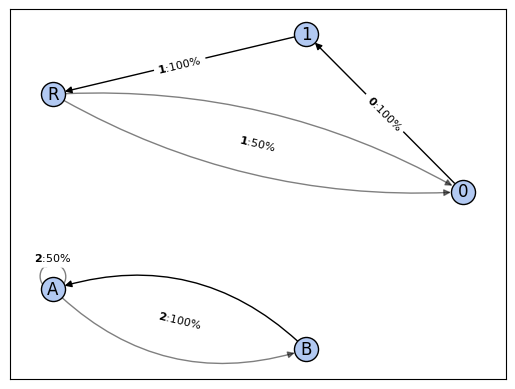

In [ ]:
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph

graph = transition_matrix_to_graph(transition_matrix=gp.transition_matrix,state_names=gp.state_names_dict)
visualize_graph(graph, draw_mixed_state=True, layout="circular")


(2, 1, 1)
[[[0.5 0. ]
  [0.  0.3]]

 [[0.5 0. ]
  [0.  0. ]]

 [[0.  0. ]
  [0.  0.7]]]
(2, 1, 1)
[[[0.7 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0.3]]

 [[0.3 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0. ]]

 [[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0.7]]]


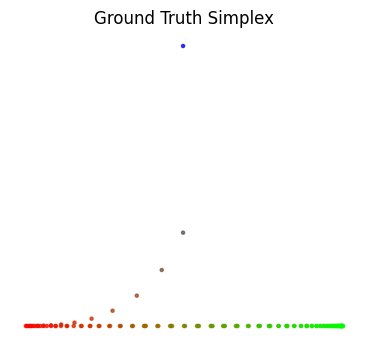

In [ ]:
from epsilon_transformers.visualization.plots import _project_to_simplex
import matplotlib.pyplot as plt

proc1 = BiasedCoin(0.5)
proc2 = BiasedCoin(0.3)
proc3 = BiasedCoin(0.7)
process = GluedProcess(proc3, GluedProcess(proc1, proc2, {0:0}), {0:0,1:1}, weights=(1, 2))
mixed_state_tree = process.derive_mixed_state_presentation(depth=14)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}
ground_truth_simplex = _project_to_simplex(np.array(list(msp_belief_index.keys())))
plt.figure(figsize=(4.5, 4))
plt.scatter(ground_truth_simplex[0], ground_truth_simplex[1], c=[k for k in list(msp_belief_index.keys())], alpha=.75, s=5)
plt.title("Ground Truth Simplex")
plt.gca().set_axis_off()
plt.show()


Transformer training


In [ ]:
import torch
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.visualization.plots import _project_to_simplex
import seaborn as sns

import numpy as np
import torch
import plotly.express as px
import matplotlib.pyplot as plt
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [ ]:
def get_transformer_data_from_process(process, n_ctx):
    mixed_state_tree = process.derive_mixed_state_presentation(depth=n_ctx+1)
    tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states
    transformer_data = [x for x in tree_paths if len(x) == n_ctx+1]
    transformer_data = torch.tensor(transformer_data)
    transformer_input = transformer_data[:, :-1]
    transformer_target = transformer_data[:, 1:]
    return transformer_input, transformer_target

def get_lower_bound_for_cross_entropy(process, n_ctx):
    mixed_state_tree = process.derive_mixed_state_presentation(depth=n_ctx+1)
    myopic_entropy = mixed_state_tree.myopic_entropy
    return myopic_entropy[1:]

In [65]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 3,
    d_model = 9,
    d_head = 3,
    d_mlp = 9,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=3,
    n_ctx=8,
    init_weights=True,
    device=device,
    seed = 999,
)

In [66]:
import torch
from torch.utils.data import IterableDataset, DataLoader
from typing import List, Tuple, Iterable


class ProcessDataset(IterableDataset):

    def __init__(self, process, sequence_length, num_samples, fixed=False):
        super().__init__()
        self.process = process
        self.sequence_length = sequence_length
        self.num_samples = num_samples
        self.fixed = fixed
        if self.fixed:
          self.samples = list(self._get_samples())
        else:
          self.samples = None

    def _get_samples(self):
      return process.yield_emissions(
            sequence_len=self.num_samples * (self.sequence_length + 1)
        )

    def __len__(self):
        return self.num_samples

    def __iter__(self) -> Iterable[Tuple[List[int]]]:
        samples = self._get_samples() if self.samples is None else iter(self.samples)
        for _ in range(self.num_samples):
            process_history = [
                next(samples) for _ in range(self.sequence_length + 1)
            ]
            yield (process_history[:-1], process_history[1:])


def process_dataset_collate_fn(batch: List[Tuple[List[int]]]):
    data = [x[0] for x in batch]
    labels = [x[1] for x in batch]
    return torch.tensor(data, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


train_dataset = ProcessDataset(process, sequence_length=n_ctx, num_samples=10000,
                                     fixed=False)
train_dataloader = DataLoader(train_dataset, batch_size=100, collate_fn=process_dataset_collate_fn)
val_dataset = ProcessDataset(process, sequence_length=n_ctx, num_samples=1000,
                                   fixed=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, collate_fn=process_dataset_collate_fn)

NameError: name 'n_ctx' is not defined

In [ ]:
proc1 = BiasedCoin(0.5)
proc2 = BiasedCoin(0.3)
proc3 = BiasedCoin(0.7)
process = GluedProcess(proc3, GluedProcess(proc1, proc2, {0:0}), {0:0,1:1}, weights=(1, 2))
transformer_inputs, transformer_targets = get_transformer_data_from_process(process, cfg.n_ctx)
minimum_loss = np.mean(get_lower_bound_for_cross_entropy(process, cfg.n_ctx))
print(f"Minimum Loss: {minimum_loss}")
transformer_inputs = transformer_inputs.to(device)
transformer_targets = transformer_targets.to(device)

(2, 1, 1)
[[[0.5 0. ]
  [0.  0.3]]

 [[0.5 0. ]
  [0.  0.7]]]
(2, 1, 1)
[[[0.7 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0.3]]

 [[0.3 0.  0. ]
  [0.  0.5 0. ]
  [0.  0.  0.7]]]


NameError: name 'get_transformer_data_from_process' is not defined

In [ ]:
model = HookedTransformer(cfg)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [ ]:
from tqdm import tqdm
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
for epoch in tqdm(range(10000)):
    train_logits = model(transformer_inputs)
    train_loss = loss_fn(train_logits.view(-1, cfg.d_vocab), transformer_targets.flatten())
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{10000}, Loss: {train_loss.item()/minimum_loss*100} percent of minimum, LR: {optimizer.param_groups[0]['lr']}")
        scheduler.step()

  0%|          | 1/10000 [00:00<1:00:21,  2.76it/s]

Epoch 1/10000, Loss: 101.7898571622817 percent of minimum, LR: 0.1


  1%|          | 101/10000 [00:40<59:36,  2.77it/s]

Epoch 101/10000, Loss: 101.09791785177111 percent of minimum, LR: 0.1


  2%|▏         | 201/10000 [01:22<1:00:04,  2.72it/s]

Epoch 201/10000, Loss: 100.96993091207098 percent of minimum, LR: 0.1


  3%|▎         | 301/10000 [02:03<59:28,  2.72it/s]

Epoch 301/10000, Loss: 100.92362798416406 percent of minimum, LR: 0.1


  4%|▍         | 401/10000 [02:44<58:19,  2.74it/s]

Epoch 401/10000, Loss: 100.90148881537284 percent of minimum, LR: 0.1


  5%|▌         | 501/10000 [03:25<59:56,  2.64it/s]

Epoch 501/10000, Loss: 100.8892646673057 percent of minimum, LR: 0.1


  6%|▌         | 601/10000 [04:06<58:22,  2.68it/s]

Epoch 601/10000, Loss: 100.88177915497096 percent of minimum, LR: 0.1


  7%|▋         | 701/10000 [04:47<57:08,  2.71it/s]

Epoch 701/10000, Loss: 100.87682164460891 percent of minimum, LR: 0.1


  8%|▊         | 801/10000 [05:28<57:13,  2.68it/s]

Epoch 801/10000, Loss: 100.8733743691916 percent of minimum, LR: 0.1


  9%|▉         | 901/10000 [06:08<55:12,  2.75it/s]

Epoch 901/10000, Loss: 100.87085731095038 percent of minimum, LR: 0.1


 10%|█         | 1001/10000 [06:58<1:02:19,  2.41it/s]

Epoch 1001/10000, Loss: 100.87063843632072 percent of minimum, LR: 0.010000000000000002


 11%|█         | 1101/10000 [07:39<1:02:41,  2.37it/s]

Epoch 1101/10000, Loss: 100.87041956169102 percent of minimum, LR: 0.010000000000000002


 12%|█▏        | 1201/10000 [08:20<58:11,  2.52it/s]

Epoch 1201/10000, Loss: 100.87022257452433 percent of minimum, LR: 0.010000000000000002


 13%|█▎        | 1301/10000 [09:01<1:00:05,  2.41it/s]

Epoch 1301/10000, Loss: 100.8700365310891 percent of minimum, LR: 0.010000000000000002


 14%|█▍        | 1401/10000 [09:41<1:03:38,  2.25it/s]

Epoch 1401/10000, Loss: 100.86985048765389 percent of minimum, LR: 0.010000000000000002


 15%|█▌        | 1501/10000 [10:22<1:11:58,  1.97it/s]

Epoch 1501/10000, Loss: 100.86964255675571 percent of minimum, LR: 0.010000000000000002


 16%|█▌        | 1601/10000 [11:02<1:14:50,  1.87it/s]

Epoch 1601/10000, Loss: 100.86947840078344 percent of minimum, LR: 0.010000000000000002


 17%|█▋        | 1701/10000 [11:43<1:15:59,  1.82it/s]

Epoch 1701/10000, Loss: 100.86930330107971 percent of minimum, LR: 0.010000000000000002


 18%|█▊        | 1801/10000 [12:23<1:12:53,  1.87it/s]

Epoch 1801/10000, Loss: 100.86912820137597 percent of minimum, LR: 0.010000000000000002


 19%|█▉        | 1901/10000 [13:03<1:09:11,  1.95it/s]

Epoch 1901/10000, Loss: 100.86896404540373 percent of minimum, LR: 0.010000000000000002


 20%|██        | 2001/10000 [13:43<1:04:03,  2.08it/s]

Epoch 2001/10000, Loss: 100.86895310167223 percent of minimum, LR: 0.0010000000000000002


 21%|██        | 2101/10000 [14:24<53:57,  2.44it/s]

Epoch 2101/10000, Loss: 100.86893121420928 percent of minimum, LR: 0.0010000000000000002


 22%|██▏       | 2201/10000 [15:04<47:16,  2.75it/s]

Epoch 2201/10000, Loss: 100.8689093267463 percent of minimum, LR: 0.0010000000000000002


 23%|██▎       | 2301/10000 [15:45<46:57,  2.73it/s]

Epoch 2301/10000, Loss: 100.86889838301482 percent of minimum, LR: 0.0010000000000000002


 24%|██▍       | 2401/10000 [16:25<45:48,  2.76it/s]

Epoch 2401/10000, Loss: 100.86886555182038 percent of minimum, LR: 0.0010000000000000002


 25%|██▌       | 2501/10000 [17:06<45:03,  2.77it/s]

Epoch 2501/10000, Loss: 100.86885460808888 percent of minimum, LR: 0.0010000000000000002


 26%|██▌       | 2601/10000 [17:46<45:20,  2.72it/s]

Epoch 2601/10000, Loss: 100.8688436643574 percent of minimum, LR: 0.0010000000000000002


 27%|██▋       | 2701/10000 [18:27<43:52,  2.77it/s]

Epoch 2701/10000, Loss: 100.86883272062592 percent of minimum, LR: 0.0010000000000000002


 28%|██▊       | 2801/10000 [19:08<45:30,  2.64it/s]

Epoch 2801/10000, Loss: 100.86881083316295 percent of minimum, LR: 0.0010000000000000002


 29%|██▉       | 2901/10000 [19:48<43:18,  2.73it/s]

Epoch 2901/10000, Loss: 100.86878894569998 percent of minimum, LR: 0.0010000000000000002


 30%|███       | 3001/10000 [20:29<43:13,  2.70it/s]

Epoch 3001/10000, Loss: 100.86878894569998 percent of minimum, LR: 0.00010000000000000003


 31%|███       | 3101/10000 [21:10<42:48,  2.69it/s]

Epoch 3101/10000, Loss: 100.86878894569998 percent of minimum, LR: 0.00010000000000000003


 32%|███▏      | 3201/10000 [21:51<43:32,  2.60it/s]

Epoch 3201/10000, Loss: 100.86878894569998 percent of minimum, LR: 0.00010000000000000003


 33%|███▎      | 3301/10000 [22:32<41:43,  2.68it/s]

Epoch 3301/10000, Loss: 100.86879988943147 percent of minimum, LR: 0.00010000000000000003


 34%|███▍      | 3401/10000 [23:13<40:43,  2.70it/s]

Epoch 3401/10000, Loss: 100.86879988943147 percent of minimum, LR: 0.00010000000000000003


 35%|███▌      | 3501/10000 [23:54<39:43,  2.73it/s]

Epoch 3501/10000, Loss: 100.86878894569998 percent of minimum, LR: 0.00010000000000000003


 36%|███▌      | 3601/10000 [24:36<39:35,  2.69it/s]

Epoch 3601/10000, Loss: 100.86878894569998 percent of minimum, LR: 0.00010000000000000003


 37%|███▋      | 3701/10000 [25:17<38:03,  2.76it/s]

Epoch 3701/10000, Loss: 100.86878894569998 percent of minimum, LR: 0.00010000000000000003


 38%|███▊      | 3801/10000 [25:58<37:48,  2.73it/s]

Epoch 3801/10000, Loss: 100.86878894569998 percent of minimum, LR: 0.00010000000000000003


 39%|███▉      | 3901/10000 [26:39<36:54,  2.75it/s]

Epoch 3901/10000, Loss: 100.86878894569998 percent of minimum, LR: 0.00010000000000000003


 40%|████      | 4001/10000 [27:19<36:44,  2.72it/s]

Epoch 4001/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-05


 41%|████      | 4101/10000 [28:00<36:21,  2.70it/s]

Epoch 4101/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-05


 42%|████▏     | 4201/10000 [28:40<35:20,  2.73it/s]

Epoch 4201/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-05


 43%|████▎     | 4301/10000 [29:21<35:10,  2.70it/s]

Epoch 4301/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-05


 44%|████▍     | 4401/10000 [30:02<34:47,  2.68it/s]

Epoch 4401/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-05


 45%|████▌     | 4501/10000 [30:42<33:25,  2.74it/s]

Epoch 4501/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-05


 46%|████▌     | 4601/10000 [31:22<33:29,  2.69it/s]

Epoch 4601/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-05


 47%|████▋     | 4701/10000 [32:03<32:41,  2.70it/s]

Epoch 4701/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-05


 48%|████▊     | 4801/10000 [32:44<31:41,  2.73it/s]

Epoch 4801/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-05


 49%|████▉     | 4901/10000 [33:25<32:55,  2.58it/s]

Epoch 4901/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-05


 50%|█████     | 5001/10000 [34:05<32:36,  2.56it/s]

Epoch 5001/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-06


 51%|█████     | 5101/10000 [34:46<33:29,  2.44it/s]

Epoch 5101/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-06


 52%|█████▏    | 5201/10000 [35:26<36:06,  2.22it/s]

Epoch 5201/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-06


 53%|█████▎    | 5301/10000 [36:07<38:08,  2.05it/s]

Epoch 5301/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-06


 54%|█████▍    | 5401/10000 [36:48<39:10,  1.96it/s]

Epoch 5401/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-06


 55%|█████▌    | 5501/10000 [37:29<37:06,  2.02it/s]

Epoch 5501/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-06


 56%|█████▌    | 5601/10000 [38:09<39:11,  1.87it/s]

Epoch 5601/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-06


 57%|█████▋    | 5701/10000 [38:49<37:32,  1.91it/s]

Epoch 5701/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-06


 58%|█████▊    | 5801/10000 [39:29<34:45,  2.01it/s]

Epoch 5801/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-06


 59%|█████▉    | 5901/10000 [40:10<30:44,  2.22it/s]

Epoch 5901/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000004e-06


 60%|██████    | 6001/10000 [40:50<25:31,  2.61it/s]

Epoch 6001/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-07


 61%|██████    | 6101/10000 [41:31<23:10,  2.80it/s]

Epoch 6101/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-07


 62%|██████▏   | 6201/10000 [42:12<23:13,  2.73it/s]

Epoch 6201/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-07


 63%|██████▎   | 6301/10000 [42:52<22:35,  2.73it/s]

Epoch 6301/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-07


 64%|██████▍   | 6401/10000 [43:33<22:07,  2.71it/s]

Epoch 6401/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-07


 65%|██████▌   | 6501/10000 [44:13<22:22,  2.61it/s]

Epoch 6501/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-07


 66%|██████▌   | 6601/10000 [44:54<21:07,  2.68it/s]

Epoch 6601/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-07


 67%|██████▋   | 6701/10000 [45:35<19:49,  2.77it/s]

Epoch 6701/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-07


 68%|██████▊   | 6801/10000 [46:15<19:26,  2.74it/s]

Epoch 6801/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-07


 69%|██████▉   | 6901/10000 [46:56<18:40,  2.76it/s]

Epoch 6901/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-07


 70%|███████   | 7001/10000 [47:37<18:32,  2.69it/s]

Epoch 7001/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-08


 71%|███████   | 7101/10000 [48:17<17:34,  2.75it/s]

Epoch 7101/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-08


 72%|███████▏  | 7201/10000 [48:58<16:43,  2.79it/s]

Epoch 7201/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-08


 73%|███████▎  | 7301/10000 [49:38<16:20,  2.75it/s]

Epoch 7301/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-08


 74%|███████▍  | 7401/10000 [50:18<15:30,  2.79it/s]

Epoch 7401/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-08


 75%|███████▌  | 7501/10000 [50:59<14:50,  2.81it/s]

Epoch 7501/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-08


 76%|███████▌  | 7601/10000 [51:39<14:34,  2.74it/s]

Epoch 7601/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-08


 77%|███████▋  | 7701/10000 [52:19<13:54,  2.76it/s]

Epoch 7701/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-08


 78%|███████▊  | 7801/10000 [53:00<13:32,  2.71it/s]

Epoch 7801/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-08


 79%|███████▉  | 7901/10000 [53:41<13:31,  2.59it/s]

Epoch 7901/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-08


 80%|████████  | 8001/10000 [54:21<13:09,  2.53it/s]

Epoch 8001/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-09


 81%|████████  | 8101/10000 [55:02<13:31,  2.34it/s]

Epoch 8101/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-09


 82%|████████▏ | 8201/10000 [55:42<13:02,  2.30it/s]

Epoch 8201/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-09


 83%|████████▎ | 8301/10000 [56:23<13:45,  2.06it/s]

Epoch 8301/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-09


 84%|████████▍ | 8401/10000 [57:04<14:32,  1.83it/s]

Epoch 8401/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-09


 85%|████████▌ | 8501/10000 [57:45<14:32,  1.72it/s]

Epoch 8501/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-09


 86%|████████▌ | 8601/10000 [58:26<12:21,  1.89it/s]

Epoch 8601/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-09


 87%|████████▋ | 8701/10000 [59:06<11:55,  1.81it/s]

Epoch 8701/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-09


 88%|████████▊ | 8801/10000 [59:46<10:39,  1.87it/s]

Epoch 8801/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-09


 89%|████████▉ | 8901/10000 [1:00:26<08:44,  2.10it/s]

Epoch 8901/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000005e-09


 90%|█████████ | 9001/10000 [1:01:07<06:59,  2.38it/s]

Epoch 9001/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000006e-10


 91%|█████████ | 9101/10000 [1:01:47<05:31,  2.71it/s]

Epoch 9101/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000006e-10


 92%|█████████▏| 9201/10000 [1:02:28<04:54,  2.71it/s]

Epoch 9201/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000006e-10


 93%|█████████▎| 9301/10000 [1:03:08<04:19,  2.70it/s]

Epoch 9301/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000006e-10


 94%|█████████▍| 9401/10000 [1:03:49<03:36,  2.76it/s]

Epoch 9401/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000006e-10


 95%|█████████▌| 9501/10000 [1:04:29<02:59,  2.78it/s]

Epoch 9501/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000006e-10


 96%|█████████▌| 9601/10000 [1:05:09<02:24,  2.76it/s]

Epoch 9601/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000006e-10


 97%|█████████▋| 9701/10000 [1:05:50<01:49,  2.73it/s]

Epoch 9701/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000006e-10


 98%|█████████▊| 9801/10000 [1:06:30<01:10,  2.81it/s]

Epoch 9801/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000006e-10


 99%|█████████▉| 9901/10000 [1:07:11<00:36,  2.68it/s]

Epoch 9901/10000, Loss: 100.86878894569998 percent of minimum, LR: 1.0000000000000006e-10


100%|██████████| 10000/10000 [1:07:50<00:00,  2.46it/s]
